In [1]:
## general imports
import json
import numpy as np

## COCO imports
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools.cocoanalyze import COCOanalyze

## plotting imports
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.io as io

In [2]:
## set paths
dataDir  = '..'
dataType = 'val2014'
annType  = 'keypoints'
prefix   = 'person_keypoints'

annFile  = '%s/annotations/%s_%s.json'%(dataDir, prefix, dataType)
resFile  = './results/%s_%s_fake%s100_results.json'%(prefix, dataType, annType)

print "COCO_GT: [%s]"%annFile
print "DTS:     [%s]"%resFile

COCO_GT: [../annotations/person_keypoints_val2014.json]
DTS:     [./results/person_keypoints_val2014_fakekeypoints100_results.json]


In [3]:
## initialize COCO ground-truth api
coco_gt = COCO( annFile )
imgIds  = sorted(coco_gt.getImgIds())
imgIds  = imgIds[0:100]
imgId   = imgIds[np.random.randint(100)]

## initialize COCO detections api
coco_dt   = coco_gt.loadRes( resFile )

## initialize COCO analyze api
coco_analyze = COCOanalyze(coco_gt, coco_dt, annType)
coco_analyze.cocoEval.params.imgIds = imgIds

loading annotations into memory...
Done (t=1.67s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!


<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=0.04s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.00s).
<mrr:2.0>Verbose Summary:
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.642
 Average Precision  (AP) @[ IoU=0.55      | area=   all | maxDets= 20 ] = 0.576
 Average Precision  (AP) @[ IoU=0.60      | area=   all | maxDets= 20 ] = 0.532
 Average Precision  (AP) @[ IoU=0.65      | area=   all | maxDets= 20 ] = 0.440
 Average Precision  (AP) @[ IoU=0.70      | area=   all | maxDets= 20 ] = 0.394
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.349
 Average Precision  (AP) @[ IoU=0.80      | area=   all | maxDets= 20 ] = 0.288
 Average Precision  (AP) @[ IoU=0.85      | area=   all | maxDets= 20 ] = 0.226
 Average Precision  (AP) @[ IoU=0.90      | area=   all | maxDets= 20 ] = 0.198
 Average Precision  (AP) @[ IoU=0.95      | area=   all | maxDets= 20 ] =

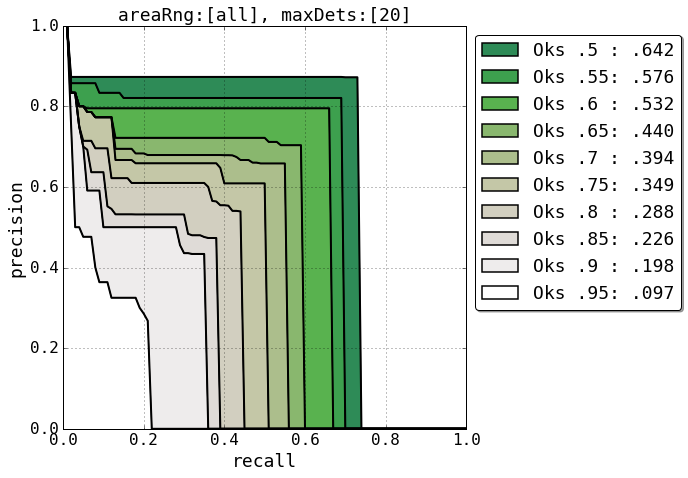

In [4]:
# use evaluate() method for standard coco evaluation
# input arguments:
#  - verbose   : verbose outputs    (default: False)
#  - makeplots : plots eval results (default: False)
#  - savedir   : path to savedir    (default: None)
#  - team_name : team name string   (default: None)

coco_analyze.evaluate(verbose=True, makeplots=True)

In [5]:
# set OKS threshold of the extended error analysis
coco_analyze.params.oksThrs       = [.85]

# set OKS threshold required to match a detection to a ground truth
coco_analyze.params.oksLocThrs    = .1

# set KS threshold limits defining jitter errors
coco_analyze.params.jitterKsThrs = [.5,.85]

# set the localization errors to analyze and in what order
# note: different order will show different progressive improvement
# to study impact of single error type, study in isolation
coco_analyze.params.err_types = ['miss','swap','inversion','jitter']

# area ranges for evaluation
# 'all' range is union of medium and large
coco_analyze.params.areaRng       = [[32 ** 2, 1e5 ** 2]]#,[[32 ** 2, 96 ** 2]],[[96 ** 2, 1e5 ** 2]]
coco_analyze.params.areaRngLbl    = ['all']#,['medium'],['large']

In [6]:
# use analyze() method for advanced error analysis 
# input arguments:
#  - check_kpts   : analyze keypoint localization errors for detections with a match (default: True)
#                 : errors types are ['jitter','inversion','swap','miss']
#  - check_scores : analyze optimal score (maximizing oks over all matches) for every detection (default: True)
#  - check_bkgd   : analyze background false positives and false negatives (default: True)

coco_analyze.analyze(check_kpts=True, check_scores=True, check_bkgd=True)

<mrr:2.0>Analyzing keypoint errors...
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=0.03s).
Finding all errors causing false positives...
Done (t=0.06s).
<mrr:2.0>DONE (t=0.09s).
<mrr:2.0>Analyzing detection scores...
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=0.02s).
<mrr:2.0>Running per image *optimal score* evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=0.03s).
<mrr:2.0>DONE (t=0.05s).


In [7]:
## after analyze() has been run the following variables are available

# list of the corrected detections
corrected_dts = coco_analyze.corrected_dts

i = 17
# info on keypoint detection localization error
print 'good: %s'%corrected_dts[i]['good']
print 'miss: %s'%corrected_dts[i]['miss']
print 'swap: %s'%corrected_dts[i]['swap']
print 'inv.: %s'%corrected_dts[i]['inversion']
print 'jit.: %s\n'%corrected_dts[i]['jitter']

# corrected keypoint locations
print 'predicted keypoints:\n %s'%corrected_dts[i]['keypoints']
print 'corrected keypoints:\n %s\n'%corrected_dts[i]['opt_keypoints']

# optimal detection score
print 'original score: %s'%corrected_dts[i]['score']
print 'optimal score:  %s\n'%corrected_dts[i]['opt_score']

# dictionary with all detection and ground truth matches
dt_gt_matches = coco_analyze.matches
print "Dt-gt match:"
for k in dt_gt_matches['dts'][corrected_dts[i]['id']][0]:
    print k, dt_gt_matches['dts'][corrected_dts[i]['id']][0][k]

good: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
miss: [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
swap: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
inv.: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
jit.: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]

predicted keypoints:
 [306, 163, 2, 312, 154, 2, 296, 153, 2, 337, 139, 2, 293.875, 239.875, 0, 351, 162, 2, 281, 153, 2, 380, 253, 2, 243, 224, 2, 337, 258, 2, 254, 247, 2, 325, 269, 2, 273, 264, 2, 303, 290, 2, 240, 275, 2, 232, 419, 2, 232, 415, 2]
corrected keypoints:
 [331.00343509551465, 163.0, 2, 332.58113883008417, 154.0, 2, 320.77253374568716, 153.0, 2, 364.081547243962, 139.0, 2, 293.875, 239.875, 0, 378.8326863537415, 162.0, 2, 308.8326863537415, 153.0, 2, 407.0500432591062, 253.0, 2, 270.0500432591062, 224.0, 2, 362.93198169534145, 258.0, 2, 279.93198169534145, 247.0, 2, 325.0, 269.0, 2, 273.0, 264.0, 2, 303.0, 290.0, 2, 240.0, 275.0, 2, 232.0, 419.0, 2, 232.0, 415.0, 2]

original score: 

<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=0.03s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.00s).
<mrr:2.0>Verbose Summary:
 Average Precision  (AP) @[ IoU=0.85      | area=   all | maxDets= 20 ] = 0.226
 Average Recall     (AR) @[ IoU=0.85      | area=   all | maxDets= 20 ] = 0.381
<mrr:2.0>Correcting error type [miss]:
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=0.03s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.00s).
<mrr:2.0>Verbose Summary:
 Average Precision  (AP) @[ IoU=0.85      | area=   all | maxDets= 20 ] = 0.264
 Average Recall     (AR) @[ IoU=0.85      | area=   all | maxDets= 20 ] = 0.424
<mrr:2.0>Correcting error type [swap]:
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=0.03s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.00s).
<mrr:2.

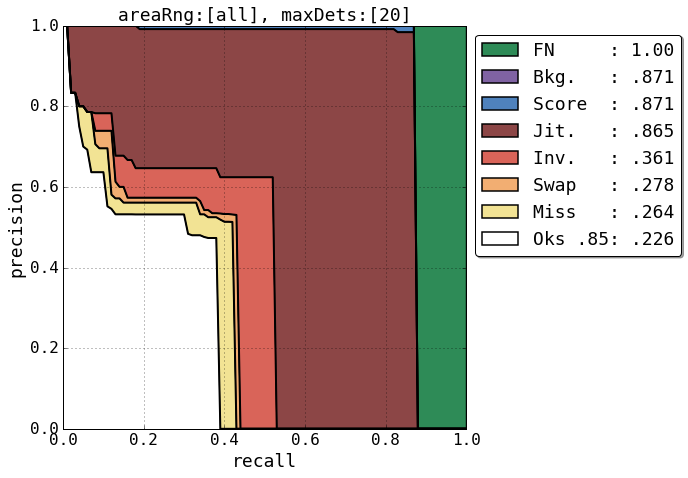

In [8]:
# use summarize() method to get the results after progressive correction of errors
# input arguments:
#  - makeplots : plots eval results (default: False)
#  - savedir   : path to savedir    (default: None)
#  - team_name : team name string   (default: None)

coco_analyze.summarize(makeplots=True)

In [9]:
## after summarize() has been run the following variables are available

# list of the missed ground-truth annotations
false_neg_gts = coco_analyze.false_neg_gts

In [10]:
## list the performance summary 
for stat in coco_analyze.stats: print stat

{'recall': 0.38129496402877699, 'oks': 0.85, 'auc': 0.22615308868279232, 'areaRng': 'all'}
{'recall': 0.42446043165467628, 'oks': 0.85, 'auc': 0.26445543212952161, 'err': 'miss', 'areaRng': 'all'}
{'recall': 0.43884892086330934, 'oks': 0.85, 'auc': 0.27766545011864691, 'err': 'swap', 'areaRng': 'all'}
{'recall': 0.52517985611510787, 'oks': 0.85, 'auc': 0.36064300575203589, 'err': 'inversion', 'areaRng': 'all'}
{'recall': 0.87050359712230219, 'oks': 0.85, 'auc': 0.86497205393922239, 'err': 'jitter', 'areaRng': 'all'}
{'recall': 0.87050359712230219, 'oks': 0.85, 'auc': 0.87128712871287128, 'err': 'score', 'areaRng': 'all'}
{'recall': 0.87050359712230219, 'oks': 0.85, 'auc': 0.87128712871287128, 'err': 'bkg_false_pos', 'areaRng': 'all'}
{'recall': 1.0, 'oks': 0.85, 'auc': 1.0, 'err': 'false_neg', 'areaRng': 'all'}
